# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.118741,False,-1.404588
1,0.223132,True,4.252431
2,0.845327,True,5.940847
3,-0.231145,False,-1.118763
4,-2.783672,False,-5.481188
...,...,...,...
995,-0.851276,False,-1.489282
996,-0.300277,True,4.404065
997,-1.688793,False,-2.602843
998,-0.016134,True,4.600415


<AxesSubplot:xlabel='v0'>

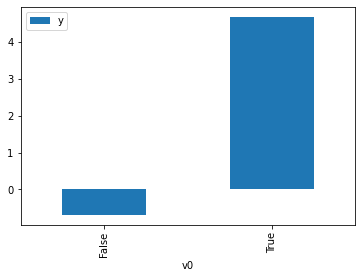

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

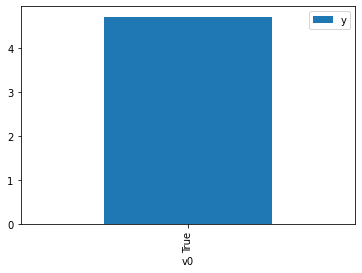

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.891559,False,0.719602,0.133566,7.486921
1,0.075070,False,1.248278,0.428585,2.333259
2,-1.110745,False,-2.643611,0.881864,1.133962
3,-0.155644,False,0.488681,0.539776,1.852620
4,0.580990,False,-0.066972,0.219603,4.553668
...,...,...,...,...,...
995,-0.475290,False,-1.218367,0.685430,1.458938
996,-0.787630,False,-2.064819,0.799645,1.250554
997,1.194658,False,2.973561,0.078919,12.671154
998,0.371789,False,-0.181822,0.296797,3.369309


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.756626,True,6.690550,0.833178,1.200224
1,0.031791,True,5.650007,0.550765,1.815655
2,-1.497212,True,4.022112,0.059576,16.785302
3,0.246304,True,4.873341,0.650091,1.538247
4,0.588816,True,3.726814,0.782985,1.277164
...,...,...,...,...,...
995,1.893244,True,7.259326,0.978349,1.022130
996,-0.203405,True,3.547857,0.437333,2.286585
997,-1.384912,True,3.165262,0.073002,13.698291
998,-0.246509,True,2.577683,0.416899,2.398663


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8085.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        09:31:19   Log-Likelihood:                         -1363.5
No. Observations:                1000   AIC:                                      2731.
Df Residuals:                     998   BIC:                                      2741.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4007      0.028     50.186      0.000       1.346       1.455
x2             4.9801      0.048    103.561      0.000       4.886       5.074
==============================================================================
Omnibus:                        7.553   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.667
Skew:                          -0.176   Prob(JB):                       0.0216
Kurtosis:                       3.244   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""